# Near CPD Profiling, Benchmarking, Optimization

In [2]:
import cProfile
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pstats
import scipy.sparse
import time
from numpy.linalg import norm
from pstats import SortKey

import cpd

np.set_printoptions(linewidth=150, precision=3, suppress=False)

%load_ext autoreload
%autoreload 2

## Near CPD v. near PD Runtime

In [3]:
dim_values = np.arange(10, 16) # np.array([10, 15, 20, 25, 30])# 2 ** np.arange(2, 5)
num_experiments = 10
methods = ("near-pd", "near-cpd-diag", "near-cpd-all", "near-cpd-all-scaled")

def run_method(method, a):
    if method == "near-pd":
        return eblp.near_pd.near_pd(a)
    elif method == "near-cpd-diag":
        return eblp.ccpd.near_cpd(a)[0]
    elif method == "near-cpd-all":
        return eblp.ccpd.near_cpd(a, regularization="all")[0]
    elif method == "near-cpd-all-scaled":
        return eblp.ccpd.near_cpd(a, regularization="all_scaled")[0]
    else:
        raise Exception("Unsupported method {}".format(method))

t = np.zeros((len(dim_values), num_experiments, len(methods)))
for k, dim in enumerate(dim_values):
    print("dim", dim)
    for i in range(num_experiments):
        a = np.random.randn(dim, dim)
        for m, method in enumerate(methods):
            result = %timeit -n2 -r1 -o -q b = run_method(method, a)
            t[k, i, m] = result.average

dim 10


NameError: name 'eblp' is not defined

near-pd         [  20.821 -164.104  431.039 -383.642]
near-cpd-diag   [  63.264 -471.742 1175.215 -979.288]
near-cpd-all    [  61.473 -458.041 1140.373 -949.826]
near-cpd-all-scaled [   88.177  -649.401  1594.059 -1305.681]
[0.001 0.001 0.003 0.001 0.002 0.002] [0.    0.    0.004 0.001 0.    0.   ]
[0.126 0.249 0.293 0.368 0.644 1.077] [0.038 0.072 0.045 0.083 0.346 0.506]
[0.127 0.255 0.287 0.37  0.667 1.084] [0.04  0.069 0.048 0.085 0.356 0.557]
[0.162 0.223 0.208 0.241 0.373 0.862] [0.09  0.085 0.064 0.089 0.423 0.737]


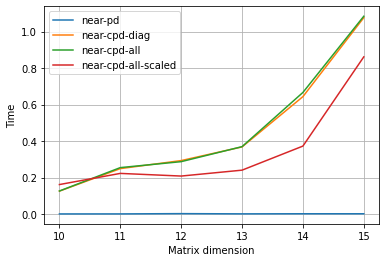

In [93]:
for m, method in enumerate(methods):
    plt.plot(dim_values, np.mean(t[:, :, m], axis=1), label=method)
plt.grid(True);
plt.xlabel("Matrix dimension")
plt.ylabel("Time")
plt.legend();

for m, method in enumerate(methods):
    print("{:<15s} {}".format(method, np.polyfit(np.log(dim_values), np.log(np.mean(t[:, :, m], axis=1)), 3)))

for m in range(len(methods)):
    print(np.mean(t[:, :, m], axis=1), np.std(t[:, :, m], axis=1))

## Profiling

In [4]:
dim = 20
a = np.random.randn(dim, dim)

In [8]:
cProfile.run('cpd.near_pd.near_pd(a, "rco")', 'near_cpd.stats')
p = pstats.Stats('near_cpd.stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)

Fri Apr  1 07:52:22 2022    near_cpd.stats

         2826078 function calls (2825481 primitive calls) in 3.595 seconds

   Ordered by: cumulative time
   List reduced from 357 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    3.595    3.595 {built-in method builtins.exec}
        1    0.000    0.000    3.595    3.595 <string>:1(<module>)
        1    0.000    0.000    3.595    3.595 /Users/olivne/ETS/eblp/src/cpd/near_pd.py:12(near_pd)
        1    0.000    0.000    3.595    3.595 /Users/olivne/ETS/eblp/src/cpd/_rco.py:491(near_pd)
        1    0.000    0.000    3.590    3.590 /Users/olivne/ETS/eblp/src/cpd/_rco.py:32(optimize)
        1    0.000    0.000    3.565    3.565 /Users/olivne/ETS/eblp/src/cpd/optim.py:115(optimize)
        6    0.000    0.000    3.548    0.591 /Users/olivne/ETS/eblp/src/cpd/optim.py:165(optimizer)
        6    0.000    0.000    3.548    0.591 /Users/olivne/opt/miniconda3/envs

In [11]:
cProfile.run('cpd.near_pd.near_pd(a, "rco", regularization="all_scaled", tol_curve=1e-3)', 'near_cpd.stats')
p = pstats.Stats('near_cpd.stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(15)

Fri Apr  1 07:53:57 2022    near_cpd.stats

         538691 function calls (538447 primitive calls) in 0.660 seconds

   Ordered by: cumulative time
   List reduced from 350 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.660    0.660 {built-in method builtins.exec}
        1    0.000    0.000    0.659    0.659 <string>:1(<module>)
        1    0.000    0.000    0.659    0.659 /Users/olivne/ETS/eblp/src/cpd/near_pd.py:12(near_pd)
        1    0.000    0.000    0.659    0.659 /Users/olivne/ETS/eblp/src/cpd/_rco.py:491(near_pd)
        1    0.000    0.000    0.657    0.657 /Users/olivne/ETS/eblp/src/cpd/_rco.py:32(optimize)
        1    0.000    0.000    0.636    0.636 /Users/olivne/ETS/eblp/src/cpd/optim.py:115(optimize)
        7    0.000    0.000    0.618    0.088 /Users/olivne/ETS/eblp/src/cpd/optim.py:165(optimizer)
        7    0.000    0.000    0.618    0.088 /Users/olivne/opt/miniconda3/envs/e

### Benchmark Frobenius Error Functional Implementations
Explicit is much faster for $n \geq 20$. For $n \leq 10$, 

In [98]:
n = 32
l = np.tril(np.random.random((n, n)))
g = l @ l.T + 0.001 * np.eye(n)
x = eblp.linalg.unravel_lower(l)
a = eblp.ccpd.frobenius_error_to_matrix(n)

%time f = eblp.ccpd.MomentCholeskyFunctionalQf(a, g)
%time f_l = f.fun(x)

%time f = eblp.ccpd.MomentCholeskyFunctionalExplicit(a, g)
%time f_l = f.fun(x)

CPU times: user 5.32 s, sys: 1.41 s, total: 6.73 s
Wall time: 3.34 s
CPU times: user 771 ms, sys: 31.9 ms, total: 803 ms
Wall time: 78.8 ms
CPU times: user 2.04 s, sys: 429 ms, total: 2.47 s
Wall time: 348 ms
CPU times: user 7.37 ms, sys: 608 µs, total: 7.98 ms
Wall time: 4.05 ms


In [18]:
n_values = np.arange(2, 28) #  2 ** np.arange(2, 11)
impls = (eblp.ccpd.MomentCholeskyFunctionalQf, eblp.ccpd.MomentCholeskyFunctionalExplicit)
eval_time = np.zeros((len(n_values), len(impls)))
for i, n in enumerate(n_values):
    l = np.tril(np.random.random((n, n)))
    g = l @ l.T + 0.001 * np.eye(n)
    x = eblp.linalg.unravel_lower(l)
    a = scipy.sparse.csr_matrix(eblp.ccpd.frobenius_error_to_matrix(n))
    for j, impl in enumerate(impls):
        result = %timeit -n1 -r1 -o -q b = impl(a, g).fun(x)
        eval_time[i, j] = result.average

QF [ 2.603 -9.472]
Explicit [ 1.205 -8.191]


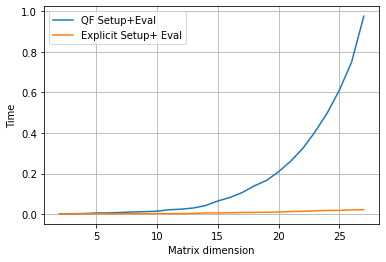

In [19]:
plt.plot(n_values, eval_time[:, 0], label="QF Setup+Eval")
plt.plot(n_values, eval_time[:, 1], label="Explicit Setup+ Eval")
plt.grid(True);
plt.xlabel("Matrix dimension")
plt.ylabel("Time")
plt.legend()
print("QF", np.polyfit(np.log(n_values), np.log(eval_time[:, 0]), 1))
print("Explicit", np.polyfit(np.log(n_values), np.log(eval_time[:, 1]), 1))

In [20]:
eval_time

array([[0.002, 0.002],
       [0.002, 0.001],
       [0.003, 0.002],
       [0.006, 0.002],
       [0.006, 0.002],
       [0.008, 0.002],
       [0.011, 0.002],
       [0.013, 0.003],
       [0.015, 0.003],
       [0.022, 0.003],
       [0.025, 0.003],
       [0.031, 0.004],
       [0.043, 0.006],
       [0.065, 0.006],
       [0.082, 0.007],
       [0.106, 0.008],
       [0.139, 0.009],
       [0.166, 0.009],
       [0.209, 0.011],
       [0.261, 0.013],
       [0.325, 0.015],
       [0.406, 0.017],
       [0.498, 0.018],
       [0.611, 0.019],
       [0.749, 0.021],
       [0.974, 0.022]])

In [21]:
n = 32
l = np.tril(np.random.random((n, n)))
g = l @ l.T + 0.001 * np.eye(n)
x = eblp.linalg.unravel_lower(l)
a = eblp.ccpd.frobenius_error_to_matrix(n)

cProfile.run('eblp.ccpd.MomentCholeskyFunctionalExplicit(a, g)', 'explicit.stats')
p = pstats.Stats('explicit.stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(30)

Tue Mar 22 11:01:49 2022    explicit.stats

         13483 function calls (13474 primitive calls) in 0.043 seconds

   Ordered by: cumulative time
   List reduced from 154 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.043    0.043 {built-in method builtins.exec}
        1    0.001    0.001    0.043    0.043 <string>:1(<module>)
        1    0.005    0.005    0.042    0.042 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:185(__init__)
        1    0.001    0.001    0.035    0.035 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:298(__init__)
        1    0.001    0.001    0.020    0.020 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:326(_build_hessian)
      529    0.002    0.000    0.014    0.000 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:332(<genexpr>)
        1    0.003    0.003    0.010    0.010 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:373(_cross_term_ij)
1113/1108    0.006    0.000    0.008    0.000 {built-in method nump

In [22]:
cProfile.run('eblp.ccpd.LltFunctional(100)', 'llt.stats')
p = pstats.Stats('llt.stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(20)

Tue Mar 22 11:01:51 2022    llt.stats

         118338 function calls (118330 primitive calls) in 0.479 seconds

   Ordered by: cumulative time
   List reduced from 137 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.479    0.479 {built-in method builtins.exec}
        1    0.011    0.011    0.479    0.479 <string>:1(<module>)
        1    0.010    0.010    0.468    0.468 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:298(__init__)
        1    0.015    0.015    0.286    0.286 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:326(_build_hessian)
        1    0.050    0.050    0.141    0.141 /Users/olivne/ETS/eblp/src/eblp/ccpd.py:373(_cross_term_ij)
      6/2    0.000    0.000    0.127    0.064 /Users/olivne/opt/miniconda3/envs/eblp/lib/python3.9/site-packages/scipy/sparse/compressed.py:27(__init__)
        2    0.000    0.000    0.124    0.062 /Users/olivne/opt/miniconda3/envs/eblp/lib/python3.9/site-packages/scipy